# Extract features from T2 WSG Data

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import time
from collections import OrderedDict

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.inspection import permutation_importance

# T2 BA + WSG PvL

In [115]:
data = pd.read_csv('T2_WSG_BA_PvL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,Ursocholic acid.2,Ursocholic acid.3,Ursocholic acid.4,Ursocholic acid.5,Ursocholic acid.6,Ursocholic acid.7,Ursodeoxycholic acid,Ursodeoxycholic acid.1,Ursodeoxycholic acid.2,Ursodeoxycholic acid.3
570_T2,0,17,62,49803,1098,4097,1471,309,28,2988,...,0,109495,0,0,0,0,0,0,0,0
571_T2,0,109,6,37007,849,3505,1757,213,49,2927,...,0,12121,0,0,0,215319,19458,0,0,0
572_T2,0,51,33,2555,124,849,665,49,60,2249,...,0,0,0,0,0,0,0,0,52161,0
573_T2,0,41,81,25427,462,2007,1179,144,80,3996,...,0,94254,0,0,0,0,0,0,0,0
574_T2,0,4,58,34821,404,7889,3162,106,27,7021,...,0,0,0,0,0,0,0,0,0,0
575_T2,0,17,37,3700,36,2194,1198,8,35,7076,...,0,24960,0,0,0,0,0,0,0,0
576_T2,0,57,34,20765,383,1422,713,104,48,3186,...,0,90501,0,0,0,16442,0,0,0,0
577_T2,0,801,142,46603,214,9062,5207,84,674,3060,...,0,154443,13560,0,0,0,0,0,0,0
578_T2,1,45,21,60347,474,8957,4196,154,80,2841,...,0,0,0,0,23337,0,0,0,0,0
580_T2,1,667,46,55194,758,4775,2706,200,547,13813,...,0,59602,0,0,0,156676,0,0,0,0


In [116]:
y = data.iloc[:,0]
x = data.iloc[:,1:200]

In [117]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=17)

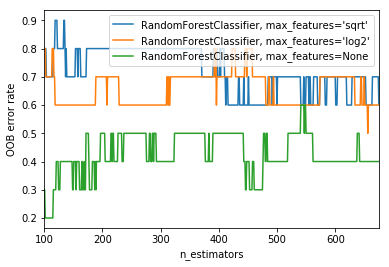

In [7]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [118]:
clf = RandomForestClassifier(n_estimators=100, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.6


In [119]:
clf_final = RandomForestClassifier(n_estimators=100, max_features=None, random_state=9, oob_score=True)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [7]:
# clf_final = RandomForestClassifier(n_estimators=250, max_features='sqrt', random_state=11, oob_score=True)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [8]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

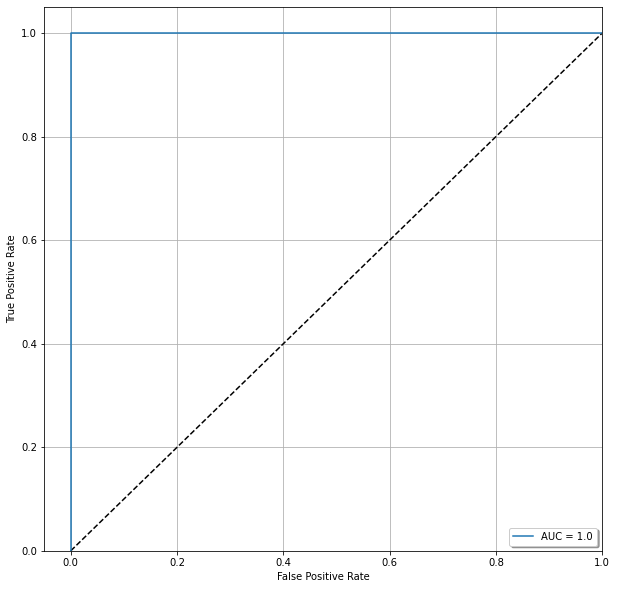

In [9]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [10]:
print(clf_final.oob_score_)

0.6


In [11]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([  2, 159,   8, 117, 173, 120,  99,   1,   4,  91,  14, 104,  12,
             24,  10,  41, 110, 149,  27,  42],
           dtype='int64')

In [12]:
for i in feats.values:
    print(i)

0.24
0.1
0.08
0.06
0.05
0.04
0.03
0.03
0.03
0.03
0.02
0.02
0.02
0.02
0.02
0.02
0.02
0.01
0.01
0.01


In [13]:
features = []
WGS = 0
BA = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        BA +=1
print(WGS)
print(BA)

8
12


In [14]:
features

['s_Lactobacillus_reuteri',
 'Lithocholic acid (NIST14)',
 's_Akkermansia_muciniphila',
 '3β-Hydroxy-5-cholenoic acid (NIST14).1',
 'Ursocholic acid.3',
 '3β-Hydroxy-5-cholenoic acid (NIST14).4',
 'Cholic acid.7',
 's_Parabacteroides_goldsteinii',
 's_Lactobacillus_johnsonii',
 'Chenodeoxycholic acid',
 's_Borrelia_anserina',
 'Cholic acid methyl ester',
 's_Paenibacillus_sp._IHB_B_3084',
 's_Chlamydia_caviae',
 's_Vibrio_sp._2521-89',
 'β-Hyodeoxycholic acid.7',
 '12-Ketodeoxycholic acid (NIST14)',
 'Deoxycholic acid (NIST14).3',
 'α-Hyodeoxycholic acid methyl ester .1',
 'β-Hyodeoxycholic acid.8']

In [120]:
result = permutation_importance(clf_final, X_test,y_test, n_repeats=10, random_state=42)
sorted_feature = result.importances_mean.argsort()[::-1]

In [121]:
top_10 = sorted_feature[0:10]
top_10

array([  4, 173,   8,   1,   2,  99, 159,  59,  60,  61])

In [85]:
top_10

array([  4, 173,   8,   1,   2,  99, 159,  59,  60,  61])

In [94]:
result.importances_mean[top_10]

array([0.1 , 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.  , 0.  , 0.  ])

In [96]:
result.importances_std[top_10]

array([0.08164966, 0.07637626, 0.07637626, 0.07637626, 0.07637626,
       0.07637626, 0.07637626, 0.        , 0.        , 0.        ])

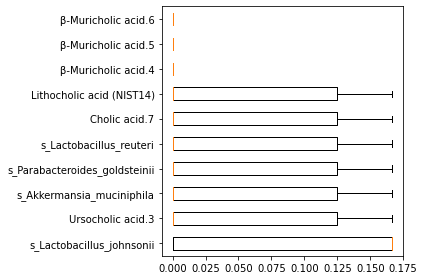

In [95]:
fig,ax = plt.subplots()
ax.boxplot(result.importances[top_10].T, vert=False,labels=X_test.columns[top_10])
fig.tight_layout()
plt.show()

Text(0.5, 1.0, 'T2 BA + WSG PvL')

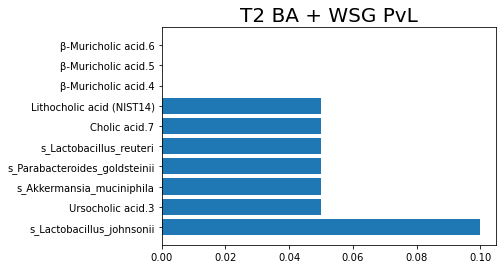

In [144]:
index = np.arange(len(top_10))
std = result.importances_std[top_10]
figure(figsize=(6,4))
plt.barh(index, result.importances_mean[top_10])
plt.yticks(index, X_test.columns[top_10], fontsize=10)
plt.title("T2 BA + WSG PvL", fontsize=20)

# T2 Metabolome + WSG PvL

In [97]:
data = pd.read_csv('T2_Known_WSG_PvL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,5-Hexenoic acid,4-Cholestenone,3β -Hydroxy-5-cholestenoic acid,3-Hydroxykynurenine,25(S)-26-Hydroxycholesterol,17-Octadecynoic acid,1-Palmitoyl-sn-glycero-3-phosphocholine,1-Palmitoyl-sn-glycero-3-phosphocholine.1,1-Hexadecyl-sn-glycero-3-phosphocholine,(+)-Fluprostenol lactone diol
570_T2,0,17,62,49803,1098,4097,1471,309,28,2988,...,0,0,0,0,0,0,77884,2736,0,0
571_T2,0,109,6,37007,849,3505,1757,213,49,2927,...,0,0,0,0,0,0,316660,2628,0,0
572_T2,0,51,33,2555,124,849,665,49,60,2249,...,10262,0,0,0,0,0,44911,0,0,15551
573_T2,0,41,81,25427,462,2007,1179,144,80,3996,...,0,0,3596,0,0,0,113042,5958,0,0
574_T2,0,4,58,34821,404,7889,3162,106,27,7021,...,0,0,0,40331,0,0,20959,0,0,0
575_T2,0,17,37,3700,36,2194,1198,8,35,7076,...,0,0,0,0,0,0,12358,0,0,0
576_T2,0,57,34,20765,383,1422,713,104,48,3186,...,0,0,0,0,0,0,120684,0,0,0
577_T2,0,801,142,46603,214,9062,5207,84,674,3060,...,0,0,18475,6138,0,0,219347,5893,6811,0
578_T2,1,45,21,60347,474,8957,4196,154,80,2841,...,0,13147,0,0,0,0,64691,0,0,9987
580_T2,1,667,46,55194,758,4775,2706,200,547,13813,...,0,0,0,0,0,0,130790,0,0,0


In [98]:
y = data.iloc[:,0]
x = data.iloc[:,1:100]

In [99]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=11)

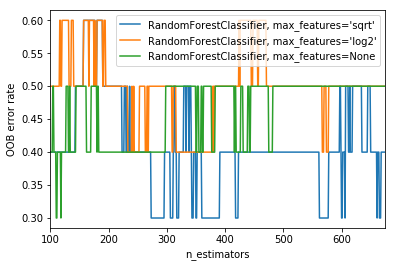

In [23]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [100]:
clf = RandomForestClassifier(n_estimators=480, max_features='sqrt', random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.6


In [101]:
clf_final = RandomForestClassifier(n_estimators=480, max_features='sqrt', oob_score=True, random_state=10)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [133]:
# clf_final = RandomForestClassifier(n_estimators=150, max_features=None, oob_score=True, random_state=9)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [102]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

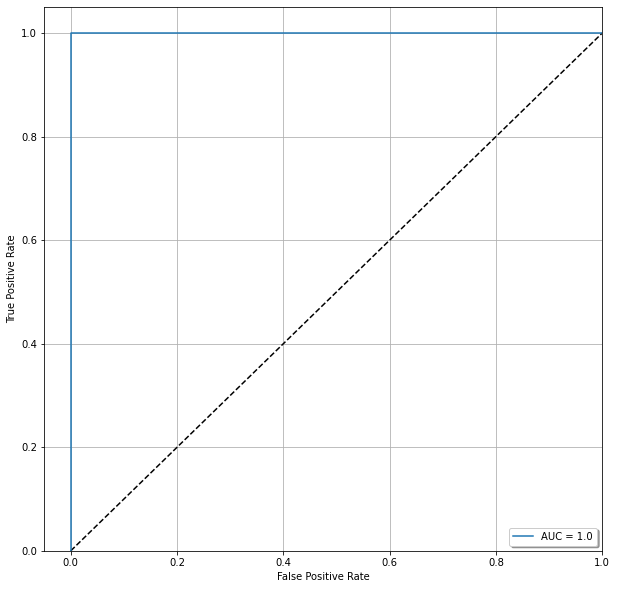

In [103]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [104]:
print(clf_final.oob_score_)

0.6


In [105]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([75, 52, 54, 8, 5, 3, 4, 71, 28, 47, 57, 85, 14, 7, 16, 17, 13, 84,
            2, 6],
           dtype='int64')

In [106]:
features = []
WGS = 0
Meta = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        Meta +=1
print(WGS)
print(Meta)

11
9


In [107]:
for i in feats.values:
    print(i)

0.0761913081095471
0.05873980899138133
0.05694208734041019
0.04235299990016971
0.04216498619014342
0.03981966767606181
0.03798542477787761
0.03311869821303784
0.03293234834115337
0.030639579381717744
0.02938754117999401
0.028401717080962365
0.027586436391467836
0.02631775980832585
0.024766230741073505
0.024591527736181826
0.02437314898006722
0.022163155968187413
0.022114488702539015
0.021638215034441452


In [108]:
features

['Bacosine',
 'Oleanolic acid methyl ester',
 '4-dihydroxyheptadec-16-en-2-yl acetate',
 's_Akkermansia_muciniphila',
 's_Lactobacillus_gasseri',
 's_Lactobacillus_murinus',
 's_Lactobacillus_johnsonii',
 'cis-5,8,11,14-Eicosatetraenoic acid.1',
 'Urobilin (NIST14)',
 'Phenol',
 '1-Phenanthrenecarboxylic acid.1',
 '1-Palmitoyl-sn-glycero-3-phosphocholine.1',
 's_Borrelia_anserina',
 's_Lachnospiraceae_bacterium_14-2',
 's_Lactobacillus_amylolyticus',
 's_Lactobacillus_acidophilus',
 's_Corynebacterium_uterequi',
 '1-Palmitoyl-sn-glycero-3-phosphocholine',
 's_Lactobacillus_reuteri',
 's_Lactobacillus_animalis']

In [109]:
result = permutation_importance(clf_final, X_test,y_test, n_repeats=10, random_state=42)
sorted_feature = result.importances_mean.argsort()[::-1]

In [110]:
top_10 = sorted_feature[0:10]
top_10

array([12,  6,  7, 67, 15, 14,  8,  2, 22,  9])

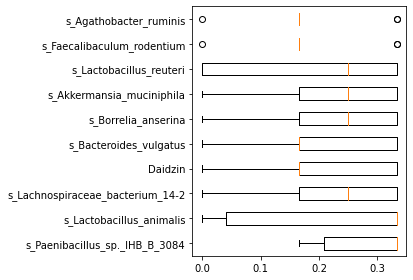

In [111]:
fig,ax = plt.subplots()
ax.boxplot(result.importances[top_10].T, vert=False,labels=X_test.columns[top_10])
fig.tight_layout()
plt.show()

# T2 BA + WSG LvCoL

In [145]:
data = pd.read_csv('T2_WSG_BA_LvCoL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,Ursocholic acid.2,Ursocholic acid.3,Ursocholic acid.4,Ursocholic acid.5,Ursocholic acid.6,Ursocholic acid.7,Ursodeoxycholic acid,Ursodeoxycholic acid.1,Ursodeoxycholic acid.2,Ursodeoxycholic acid.3
578_T2,0,45,21,60347,474,8957,4196,154,80,2841,...,0,0,0,0,23337,0,0,0,0,0
580_T2,0,667,46,55194,758,4775,2706,200,547,13813,...,0,59602,0,0,0,156676,0,0,0,0
581_T2,0,1059,10,68130,606,5707,3008,192,867,15042,...,0,0,0,0,0,0,0,0,0,0
582_T2,0,12,40,21043,1720,3848,2512,486,101,69794,...,0,0,0,0,0,0,0,0,0,0
583_T2,0,5,15,60703,2603,3576,1875,799,27,25215,...,0,0,0,0,0,0,0,0,0,0
584_T2,0,58,30,149710,1123,29122,14053,333,65,31932,...,0,0,0,0,0,0,0,0,0,0
585_T2,0,71,8,32456,220,19410,10916,67,95,2951,...,0,0,0,0,0,0,0,0,0,0
586_T2,0,6,50,136788,1327,14531,7421,326,21,118275,...,0,0,0,0,0,0,0,0,0,0
589_T2,1,31,16,6922,235,4114,2404,54,67,5848,...,0,52467,0,0,16117,0,9263,0,0,0
591_T2,1,45,65,56717,392,29198,4325,101,54,49966,...,0,364534,0,0,0,0,0,0,0,0


In [146]:
y = data.iloc[:,0]
x = data.iloc[:,1:200]

In [147]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=17)

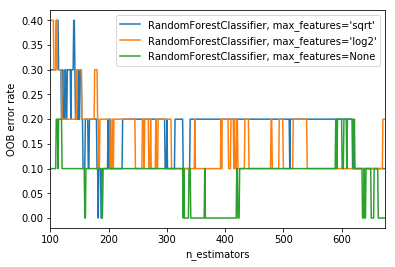

In [38]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [148]:
clf = RandomForestClassifier(n_estimators=400, max_features= None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 0.8


In [149]:
clf_final = RandomForestClassifier(n_estimators=400, max_features=None, oob_score=True, random_state=9)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [150]:
# clf_final = RandomForestClassifier(n_estimators=100, max_features=None, oob_score=True, random_state=9)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [151]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

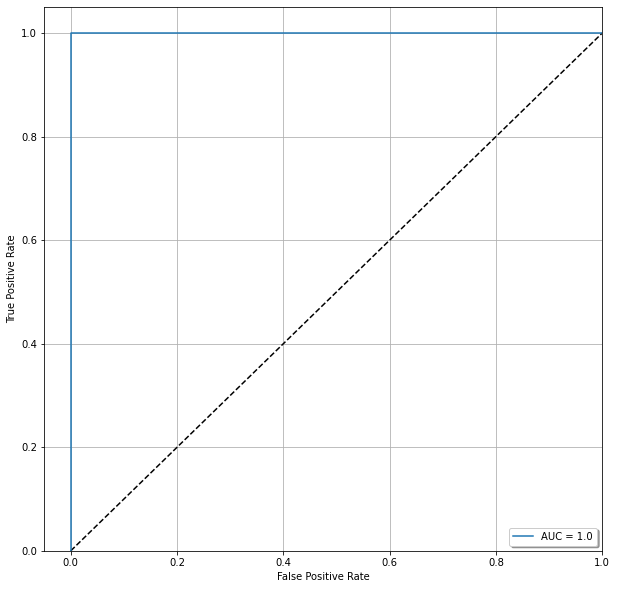

In [152]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [153]:
print(clf_final.oob_score_)

0.9


In [154]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([117, 143, 159, 141, 104,   6,   3, 161, 138, 165, 160, 142, 173,
            129,  33, 167, 100,  26,  66, 166],
           dtype='int64')

In [155]:
features = []
WGS = 0
BA = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        BA +=1
print(WGS)
print(BA)

3
17


In [156]:
for i in feats.values:
    print(i)

0.115
0.1075
0.095
0.065
0.055
0.05
0.0425
0.04
0.0375
0.0375
0.0375
0.0325
0.025
0.025
0.025
0.0225
0.0175
0.015
0.0125
0.01


In [157]:
features

['3β-Hydroxy-5-cholenoic acid (NIST14).1',
 'Cholic acid (NIST14).19',
 'Lithocholic acid (NIST14)',
 'Cholic acid (NIST14).17',
 'Cholic acid methyl ester',
 's_Lactobacillus_animalis',
 's_Lactobacillus_murinus',
 'Tauroursodeoxycholic acid (NIST14).1',
 'Cholic acid (NIST14).14',
 'Taurocholic acid.1',
 'Tauroursodeoxycholic acid (NIST14)',
 'Cholic acid (NIST14).18',
 'Ursocholic acid.3',
 'Cholic acid (NIST14).5',
 'α-Hyodeoxycholic acid methyl ester .7',
 'Taurocholic acid.3',
 'Cholic acid.8',
 'α-Hyodeoxycholic acid methyl ester ',
 'β-Muricholic acid.11',
 'Taurocholic acid.2']

In [158]:
result = permutation_importance(clf_final, X_test,y_test, n_repeats=10, random_state=42)
sorted_feature = result.importances_mean.argsort()[::-1]
top_10 = sorted_feature[0:10]
top_10

array([181,  67,  65,  64,  63,  62,  61,  60,  59,  58])

In [161]:
result.importances_mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Text(0.5, 1.0, 'T2 BA + WSG LvCoL')

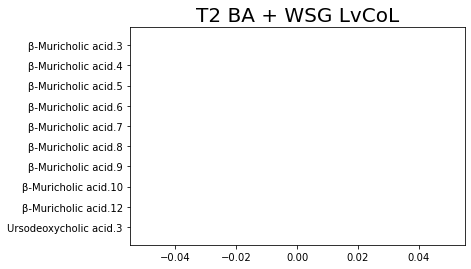

In [159]:
index = np.arange(len(top_10))
std = result.importances_std[top_10]
figure(figsize=(6,4))
plt.barh(index, result.importances_mean[top_10])
plt.yticks(index, X_test.columns[top_10], fontsize=10)
plt.title("T2 BA + WSG LvCoL", fontsize=20)

# T2 Metabolome + WSG LvCoL

In [48]:
data = pd.read_csv('T2_Known_WSG_LvCoL.csv', index_col = 0)
data = data.T
data

,Treatment,s_Pseudobutyrivibrio_ruminis,s_Parabacteroides_goldsteinii,s_Lactobacillus_reuteri,s_Lactobacillus_murinus,s_Lactobacillus_johnsonii,s_Lactobacillus_gasseri,s_Lactobacillus_animalis,s_Lachnospiraceae_bacterium_14-2,s_Akkermansia_muciniphila,...,5-Hexenoic acid,4-Cholestenone,3β -Hydroxy-5-cholestenoic acid,3-Hydroxykynurenine,25(S)-26-Hydroxycholesterol,17-Octadecynoic acid,1-Palmitoyl-sn-glycero-3-phosphocholine,1-Palmitoyl-sn-glycero-3-phosphocholine.1,1-Hexadecyl-sn-glycero-3-phosphocholine,(+)-Fluprostenol lactone diol
578_T2,0,45,21,60347,474,8957,4196,154,80,2841,...,0,13147,0,0,0,0,64691,0,0,9987
580_T2,0,667,46,55194,758,4775,2706,200,547,13813,...,0,0,0,0,0,0,130790,0,0,0
581_T2,0,1059,10,68130,606,5707,3008,192,867,15042,...,0,0,0,0,0,0,101779,0,0,0
582_T2,0,12,40,21043,1720,3848,2512,486,101,69794,...,0,0,0,0,0,0,23593,0,0,0
583_T2,0,5,15,60703,2603,3576,1875,799,27,25215,...,0,0,0,0,0,0,32815,0,0,0
584_T2,0,58,30,149710,1123,29122,14053,333,65,31932,...,0,5808,0,0,0,16693,0,0,12696,0
585_T2,0,71,8,32456,220,19410,10916,67,95,2951,...,0,0,0,0,0,0,61503,2503,0,6818
586_T2,0,6,50,136788,1327,14531,7421,326,21,118275,...,9471,0,0,0,0,0,54530,0,13191,0
589_T2,1,31,16,6922,235,4114,2404,54,67,5848,...,0,11199,0,0,9072,0,524927,0,89766,0
591_T2,1,45,65,56717,392,29198,4325,101,54,49966,...,0,10248,2885,0,13917,0,680404,0,19384,0


In [49]:
y = data.iloc[:,0]
x = data.iloc[:,1:100]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.35, random_state=11)

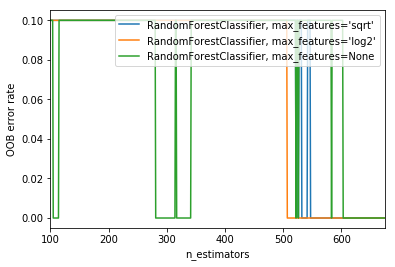

In [51]:
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt", 
                               random_state=42)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True, 
                               random_state=42)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True, 
                               random_state=42))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 675

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [52]:
clf = RandomForestClassifier(n_estimators=300, max_features=None, random_state=42)
all_accuracies = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=5)
print('Mean Validation Scores: ' ,end='')
print(np.mean(all_accuracies))

Mean Validation Scores: 1.0


In [53]:
clf_final = RandomForestClassifier(n_estimators=300, max_features=None, oob_score=True, random_state=9)
clf_final.fit(X_train,y_train)
y_pred = clf_final.predict(X_test)
print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [157]:
# clf_final = RandomForestClassifier(n_estimators=100, max_features=None, oob_score=True, random_state=9)
# clf_final.fit(X_train,y_train)
# y_pred = clf_final.predict(X_test)
# print("Test Set Accuracy:",metrics.accuracy_score(y_test, y_pred))

Test Set Accuracy: 1.0


In [54]:
rf_probs = clf_final.predict_proba(X_test)[:, 1]
roc_value = roc_auc_score(y_test, rf_probs)
roc_value

1.0

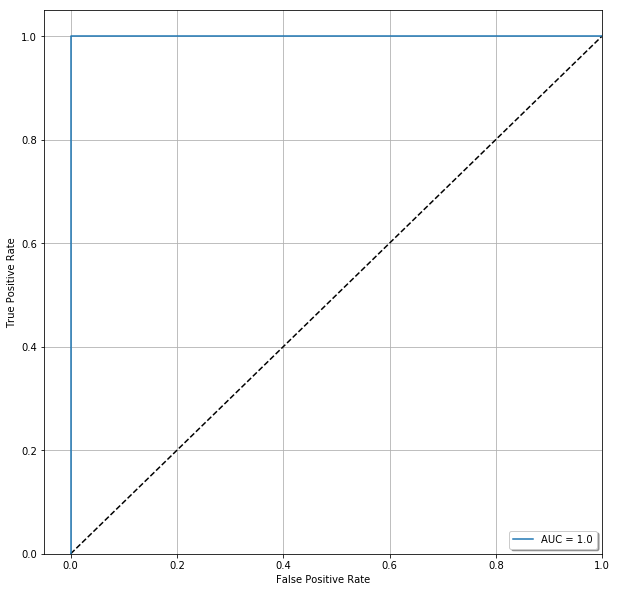

In [55]:
# get roc/auc info
Y_score = clf_final.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()

In [56]:
print(clf_final.oob_score_)

1.0


In [57]:
feature_importance = pd.Series(clf_final.feature_importances_).sort_values(ascending=False)
feats = feature_importance[0:20]
feats.index

Int64Index([38, 52, 71, 28, 40, 84, 45, 43, 86, 26, 6, 3, 68, 30, 80, 67, 62,
            16, 79, 57],
           dtype='int64')

In [58]:
features = []
WGS = 0
Meta = 0
for i in feats.index:
    features.append(x.iloc[:,i].name)
    if i <= 26:
         WGS += 1
    else: 
        Meta +=1
print(WGS)
print(Meta)

4
16


In [59]:
for i in feats.values:
    print(i)

0.12666666666666668
0.11
0.10666666666666667
0.1
0.09333333333333334
0.07666666666666666
0.06
0.04
0.04
0.03666666666666667
0.02666666666666667
0.02666666666666667
0.016666666666666666
0.016666666666666666
0.013333333333333334
0.013333333333333334
0.01
0.01
0.01
0.006666666666666667


In [60]:
features

['phosphocholine (NIST14)',
 'Oleanolic acid methyl ester',
 'cis-5,8,11,14-Eicosatetraenoic acid.1',
 'Urobilin (NIST14)',
 'phosphocholine (NIST14).2',
 '1-Palmitoyl-sn-glycero-3-phosphocholine',
 'Phytomonic acid',
 'phosphocholine (NIST14).4',
 '1-Hexadecyl-sn-glycero-3-phosphocholine',
 'Urobilin',
 's_Lactobacillus_animalis',
 's_Lactobacillus_murinus',
 'Coproporphyrin I',
 'Urobilin (NIST14).2',
 '3β -Hydroxy-5-cholestenoic acid',
 'Daidzin',
 'Medicagenic acid.1',
 's_Lactobacillus_amylolyticus',
 '4-Cholestenone',
 '1-Phenanthrenecarboxylic acid.1']